In [ ]:
!pip install --quiet torch tensorflow matplotlib seaborn ntlk IPython

# Imports and Methods

In [2]:
# Core Python and Standard Libraries
import re
import json

# Data Handling and Analysis
import numpy as np
import pandas as pd

# Text Processing and NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Machine Learning and Metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

# PyTorch and Torch Utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Progress Bar
from tqdm import tqdm
tqdm.pandas()

# Image Processing (if required)
import torchvision.transforms as transforms

# Device Configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# NLTK Downloads
nltk.data.path.append('./nltk_data')
nltk.download('punkt_tab', download_dir='./nltk_data')
nltk.download('wordnet', download_dir='./nltk_data')
nltk.download('stopwords', download_dir='./nltk_data')

# Stopwords Configuration
english_stopwords = set(stopwords.words('english'))


[nltk_data] Downloading package punkt_tab to ./nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to ./nltk_data...
[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


**Util Methods**

In [11]:
def clean_pipeline(text):
    """
    Method to clean the text by removing special characters, numbers, and converting to lowercase.
    """
    text = text.lower() # Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)  # Remove specific punctuations
    text = re.sub(r'[^\w\s.,!?-]', '', text)  # Remove non-ASCII and emojis
    text = re.sub(r'([.,!?-])', r' \1 ', text)  # Add space around specific punctuations
    text = re.sub(r'\s{2,}', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'(.)\1+', r'\1\1', text)  # Limit character repetition (e.g., "soooo" -> "soo")
    return text.strip()  # Remove leading and trailing whitespaces

def tokenize(text):
    """
    Method to tokenize the text into words
    """
    return word_tokenize(text)

def preprocess_pipeline(text):
    """
    Method to preprocess text data by tokenize, remove stopwords, and lemmatize.
    """
    tokens = tokenize(text)
    lemmatizer = WordNetLemmatizer()
    processed = [lemmatizer.lemmatize(t) for t in tokens if t not in english_stopwords]
    return ' '.join(processed)


#  Methods for Prediction and displaying in HTML Cards
def predict_sentiment(review, model, tokenizer):
    """
    Method for predicting sentiment of a review using a trained model and tokenizer.
    """
    review = clean_pipeline(review)
    review = preprocess_pipeline(review)
    # tokenize and pad the review
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence, maxlen=200)[0]
     # Convert padded_sequence to a PyTorch tensor and move to the device
    padded_sequence = torch.tensor(padded_sequence, dtype=torch.long).unsqueeze(0).to(device)
    prediction = model(padded_sequence)

    # sentiment = 'Positive 😄' if prediction > 0.5 else 'Negative'
    if prediction > 0.9:
        sentiment = 'Positive 😍'
    elif prediction > 0.7:
        sentiment = 'Positive 😄'
    elif prediction > 0.5:
        sentiment = 'Positive 😀'
    elif prediction > 0.3:
        sentiment = 'Negative 😤'
    elif prediction > 0.1:
        sentiment = 'Negative 😨'
    else:
        sentiment = 'Negative 😫'
    return sentiment, prediction.item()

def display_reviews(reviews, model, tokenizer):
    """
    Creates HTML Cards and displays the sentiment prediction results
    """
    html_content = """
    <style>
        .review-card {
            border: 1px solid #ccc;
            border-radius: 10px;
            box-shadow: 2px 2px 8px rgba(0,0,0,0.2);
            margin: 20px;
            padding: 15px;
            font-family: Arial, sans-serif;
            background: #f9f9f9;
        }
        .review-title {
            font-size: 18px;
            font-weight: bold;
            margin-bottom: 10px;
            color: #333;
        }
        .review-text {
            font-size: 16px;
            margin-bottom: 10px;
            color: #555;
        }
        .review-stars {
            font-size: 16px;
            color: #fff;
            background: #F04614;
            padding: 5px 10px;
            border-radius: 5px;
            display: inline-block;
        }
        .review-label {
            font-size: 14px;
            margin-top: 10px;
            color: #666;
            font-weight: bold;
        }
        .predicted {
            font-size: 14px;
            margin-top: 10px;
            color: #666;
            font-weight: bold;
        }
    </style>
    """

    # Dynamically generate review cards
    for i, review in enumerate(reviews, start=1):
        sentiment, score = predict_sentiment(review["review"], model, tokenizer)
        sentiment_class = "positive" if sentiment == "positive" else "negative"

        rating = review.get("rating", "N/A")

        html_content += f"""
        <div class="review-card">
            <div class="review-title">Review {i}</div>
            <div class="review-text">{review['review']}</div>
            <div class="review-label">Actual Review in IMDB: </div>
            <div class="review-stars">{rating}</div>
            <div class="review-label {sentiment_class}">Actual Sentiment: {review['label']}</div>
            <div class="predicted">Predicted Sentiment: {sentiment.capitalize()} | Score: {score:.4f}</div>
        </div>
        """

    # Display the HTML content
    display(HTML(html_content))

# Methods for Creating metrics for Final Model
def create_performance_report(train_loss_list, val_loss_list,
                            train_acc_list, val_acc_list,
                            y_true, y_pred, epochs):
    """
    Creates a comprehensive performance report with multiple subplots
    showing training history, metrics, and confusion matrices.
    """
    # Set the style - using default matplotlib style
    plt.style.use('default')
    # Apply seaborn styling properties
    sns.set_context("notebook", font_scale=1.0)

    # Create figure with GridSpec
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 2)

    # Training History Plots
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    plot_training_history(train_loss_list, val_loss_list, epochs, "Loss", ax1)
    plot_training_history(train_acc_list, val_acc_list, epochs, "Accuracy", ax2)

    # Metrics Plot
    ax3 = fig.add_subplot(gs[1, :])
    metrics = calculate_metrics(y_true, y_pred)
    plot_metrics(metrics, ax3)

    # Confusion Matrices
    ax4 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[2, 1])
    plot_confusion_matrices(y_true, y_pred, ax4, ax5)

    # Adjust layout
    plt.tight_layout()
    return fig

def plot_training_history(train_data, val_data, epochs, metric_name, ax):
    """Plot training and validation metrics."""
    actual_epochs = len(val_data)
    epochs_range = range(1, actual_epochs + 1)  # Update epochs range

    ax.plot(epochs_range, train_data[:actual_epochs], 'b-', label=f'Training {metric_name}', linewidth=2)  # Slice train_data
    ax.plot(epochs_range, val_data, 'r--', label=f'Validation {metric_name}', linewidth=2)
    ax.set_xlabel('Epochs', fontsize=10)
    ax.set_ylabel(metric_name, fontsize=10)
    ax.set_title(f'Training and Validation {metric_name}', fontsize=12, pad=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)
    ax.tick_params(labelsize=8)

def calculate_metrics(y_true, y_pred):
    """Calculate various performance metrics."""
    return {
        'F1-Score': f1_score(y_true, y_pred, average='macro'),
        'Precision': precision_score(y_true, y_pred, average='macro'),
        'Recall': recall_score(y_true, y_pred, average='macro'),
        'Accuracy': accuracy_score(y_true, y_pred)
    }

def plot_metrics(metrics, ax):
    """Create a horizontal bar plot of metrics."""
    colors = sns.color_palette("Pastel2", len(metrics))
    bars = ax.barh(list(metrics.keys()), list(metrics.values()), color=colors)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_title('Model Performance Metrics', fontsize=12, pad=10)
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}', va='center', fontsize=12)

    ax.tick_params(labelsize=12)

def plot_confusion_matrices(y_true, y_pred, ax1, ax2):
    """Plot confusion matrices with raw counts and percentages."""
    cm = confusion_matrix(y_true, y_pred)

    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(2), yticklabels=range(2),
                ax=ax1, cbar=True)
    ax1.set_xlabel('Predicted Label', fontsize=10)
    ax1.set_ylabel('True Label', fontsize=10)
    ax1.set_title('Confusion Matrix (Raw Counts)', fontsize=12, pad=10)
    ax1.tick_params(labelsize=8)

    # Percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=range(2), yticklabels=range(2),
                ax=ax2, cbar=True)
    ax2.set_xlabel('Predicted Label', fontsize=10)
    ax2.set_ylabel('True Label', fontsize=10)
    ax2.set_title('Confusion Matrix (Percentages)', fontsize=12, pad=10)
    ax2.tick_params(labelsize=8)

def display_metric_and_confusion_metrics(y_true, y_pred):
    plt.style.use('default')
    # Apply seaborn styling properties
    sns.set_context("notebook", font_scale=1.0)

    # Create figure with GridSpec
    fig = plt.figure(figsize=(20, 9))
    gs = fig.add_gridspec(2, 2)

    # Metrics Plot
    ax3 = fig.add_subplot(gs[0, :])
    metrics = calculate_metrics(y_true, y_pred)
    plot_metrics(metrics, ax3)

    # Confusion Matrices
    ax4 = fig.add_subplot(gs[1, 0])
    ax5 = fig.add_subplot(gs[1, 1])
    plot_confusion_matrices(y_true, y_pred, ax4, ax5)

    # Adjust layout
    plt.tight_layout()
    return fig

def display_images_and_predictions(images, labels, model, transform, device):
    """
    Function to display a batch of images, make predictions and compare with actual labels.
    """
    # Display the first 6 images in the batch with their corresponding labels
    print("Sample Images from Training Batch", "\n")
    fig, axes = plt.subplots(1, 6, figsize=(12, 2))
    for i in range(6):
        axes[i].imshow(images[i].squeeze(), cmap='gray')  # Remove singleton dimensions
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis('off')
    plt.show()

    # Now perform inference for all images in the batch
    with torch.no_grad():  # No need to track gradients during inference
        images = images.to(device)  # Move images to the correct device (CPU/GPU)
        outputs = model(images)  # Model inference
        _, predicted = torch.max(outputs, 1)  # Get predicted class

    # Display predictions and actual labels for comparison
    for i in range(min(6, len(images))):  # Display up to 6 images
        print(f"Predicted: {predicted[i].item()} | Actual: {labels[i].item()}")

**LSTM Model Class and Dataset Class for DataLoader**

In [6]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size) # embedding layer - input into vector representation
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True) # LSTM layer
        self.dropout = nn.Dropout(dropout) # dropout layer
        self.fc = nn.Linear(hidden_size, output_size)  # Linear layer for output
        self.sigmoid = nn.Sigmoid() # Sigmoid layer for converting binary classification

    def forward(self, x):
        x = x.long() # converting feature to long
        x = self.embedding(x) # map input to vector
        o, _ =  self.lstm(x) # pass forward to lstm
        o = o[:, -1, :] # get last sequence output
        o = self.dropout(o) # apply dropout and fully connected layer
        o = self.fc(o)
        o = self.sigmoid(o) # sigmoid Layer

        return o

class ReviewDataset(Dataset):
    def __init__(self, data, tokenizer, maxlen=200):
        """
        Args:
            data (DataFrame): The dataset containing 'review' and 'sentiment'.
            tokenizer (Tokenizer): Tokenizer fitted on training data.
            maxlen (int): Maximum length for padding sequences.
        """
        self.reviews = data['processed_review'].values
        self.sentiments = data['label'].values
        self.tokenizer = tokenizer
        self.maxlen = maxlen

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        # Tokenize and pad the review
        review = self.reviews[idx]
        review_seq = self.tokenizer.texts_to_sequences([review])
        review_padded = pad_sequences(review_seq, maxlen=self.maxlen)[0]

        # Convert sentiment to tensor (assuming binary classification)
        sentiment = torch.tensor(self.sentiments[idx], dtype=torch.long)

        return torch.tensor(review_padded, dtype=torch.long), sentiment


# EDA

In [4]:
df = pd.read_csv("/content/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
def transform_label(label):
    return 1 if label == 'positive' else 0

df['label'] = df['sentiment'].apply(transform_label)
df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [7]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [8]:
# Creating a column for counting the number of words in each sentence
df['review_length'] = df.review.apply(lambda x: len(x.split()))

df_pos = df[df['sentiment']== 'positive']
df_neg = df[df['sentiment']== 'negative']

pos_desc = df_pos['review_length'].describe()
neg_desc = df_neg['review_length'].describe()

desc_df = pd.concat([pos_desc, neg_desc], axis=1, keys=['Positive', 'Negative'])
display(desc_df)

,Positive,Negative
count,25000.000000,25000.000000
mean,232.849320,229.464560
std,177.497046,164.947795
min,10.000000,4.000000
25%,125.000000,128.000000
50%,172.000000,174.000000
75%,284.000000,278.000000
max,2470.000000,1522.000000


- For Positive Reviews, we have maximum words of 2470 and minimum words of 10. While the average words is 232.<br>
- For Negative Reviews, we have maximum words 1522 and minimum words 4. While the average words is 229.

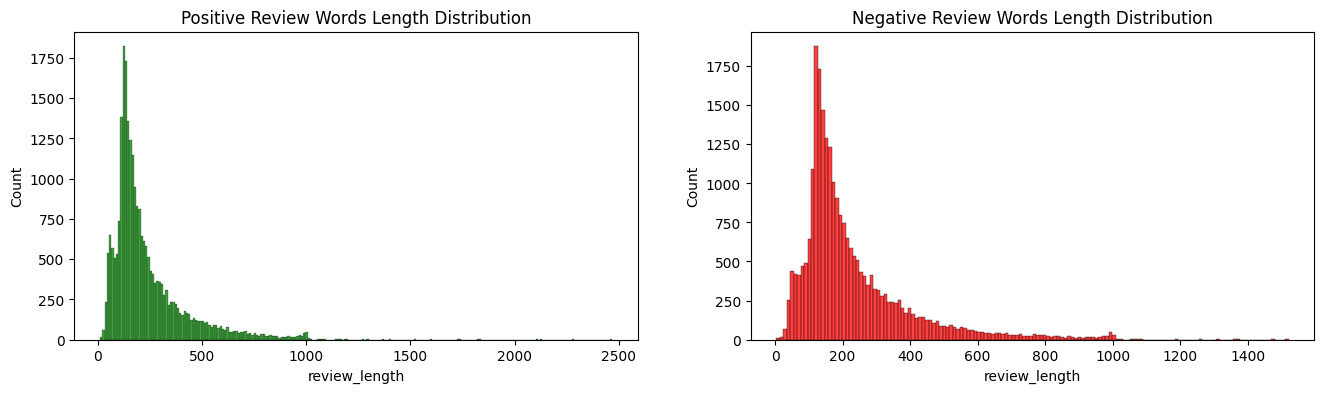

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16,4))
sns.histplot(df_pos, x='review_length', ax=axes[0], color='g')
axes[0].set_title("Positive Review Words Length Distribution")
sns.histplot(df_neg, x='review_length', ax=axes[1], color='r')
axes[1].set_title("Negative Review Words Length Distribution")
plt.show()

Minimum length reviews in positive and negative

In [10]:
print("Minimum length reviews in positive and negative", "\n")
positive_min = df_pos[df_pos['review_length'] == df_pos['review_length'].min()]['review'].item()
print('Positive: ',positive_min)

negative_min = df_neg[df_neg['review_length'] == df_neg['review_length'].min()]['review'].item()
print('Negative: ', negative_min)

Minimum length reviews in positive and negative 

Positive:  Brilliant and moving performances by Tom Courtenay and Peter Finch.
Negative:  Primary plot!Primary direction!Poor interpretation.


# Pre-Processing

In [11]:
df['clean'] = df['review'].apply(clean_pipeline)
df['processed_review'] = df['clean'].apply(preprocess_pipeline)
df.head()

,review,sentiment,label,review_length,clean,processed_review
0,One of the other reviewers has mentioned that ...,positive,1,307,one of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,162,a wonderful little production . the filming te...,wonderful little production . filming techniqu...
2,I thought this was a wonderful way to spend ti...,positive,1,166,i thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,0,138,basically there s a family where a little boy ...,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,petter mattei s love in the time of money is a...,petter mattei love time money visually stunnin...


In [12]:
# keep only processed and label columns
df[['processed_review', 'label']].to_csv('/content/imdb_processed.csv', index=False, header=True)

# Train Test Split using Dataloader

In [13]:
data = pd.read_csv('/content/imdb_processed.csv')
data.head()

,processed_review,label
0,one reviewer mentioned watching oz episode hoo...,1
1,wonderful little production . filming techniqu...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1


In [14]:
# Initial train-test split (80% train, 20% test+validation)
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)

# Further split temp_data into validation and test (40% & 60% each)
val_data, test_data = train_test_split(temp_data, test_size=0.6, random_state=42)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 40000
Validation size: 4000
Test size: 6000


In [15]:
# Tokenizer setup
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['processed_review'])

# datasets for train, validation, and test
train_dataset = ReviewDataset(train_data, tokenizer, maxlen=200)
val_dataset = ReviewDataset(val_data, tokenizer, maxlen=200)
test_dataset = ReviewDataset(test_data, tokenizer, maxlen=200)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
# Save tokenizer for future use
with open("tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())

# Model Training and Validation

In [7]:
# model hyperparamters
vocab_size = 5000
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.3

# model initialization
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

SentimentModel(
  (embedding): Embedding(5000, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [42]:
# training config
lr = 0.001
criterion = nn.BCELoss()
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 5
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}

In [43]:
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    model.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(train_loader):
        # add epoch meta info
        epochloop.set_postfix_str(f'Training batch {id}/{len(train_loader)}')

        # move to device
        feature, target = feature.to(device), target.to(device)

        # reset optimizer
        optim.zero_grad()

        # forward pass
        out = model(feature)

        # acc
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # clip grad
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # update optimizer
        optim.step()

        # free some memory
        del feature, target, predicted

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(train_acc / len(train_loader))

    ####################
    # validation model #
    ####################

    model.eval()
    y_true = []
    y_pred = []
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(val_loader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(val_loader)}')

            # move to device
            feature, target = feature.to(device), target.to(device)

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()
            y_true.extend(target.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            # free some memory
            del feature, target, predicted

        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_acc / len(val_loader))

    # reset model mode
    model.train()

    # add epoch meta info
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(val_loader):.3f} | Val Acc: {val_acc / len(val_loader):.3f}')

    # print epoch
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_loader):.3f} | Val Loss: {val_loss / len(val_loader):.3f} Val Acc: {val_acc / len(val_loader):.3f}')
        epochloop.update()

Training:  40%|████      | 2/5 [01:17<03:51, 77.33s/it, Training batch 3/1250]

Epoch 1/5 | Train Loss: 0.468 Train Acc: 0.775 | Val Loss: 0.328 Val Acc: 0.861


Training:  80%|████████  | 4/5 [02:34<00:48, 48.72s/it, Training batch 3/1250]

Epoch 2/5 | Train Loss: 0.290 Train Acc: 0.880 | Val Loss: 0.290 Val Acc: 0.880


Training: 100%|██████████| 5/5 [03:53<00:00, 43.92s/it, Training batch 3/1250]

Epoch 3/5 | Train Loss: 0.223 Train Acc: 0.912 | Val Loss: 0.298 Val Acc: 0.883


Training: 7it [05:10, 52.73s/it, Training batch 3/1250]

Epoch 4/5 | Train Loss: 0.161 Train Acc: 0.940 | Val Loss: 0.335 Val Acc: 0.883


Training: 100%|██████████| 5/5 [06:26<00:00, 77.39s/it, Val Loss: 0.390 | Val Acc: 0.871]

Epoch 5/5 | Train Loss: 0.088 Train Acc: 0.971 | Val Loss: 0.390 Val Acc: 0.871


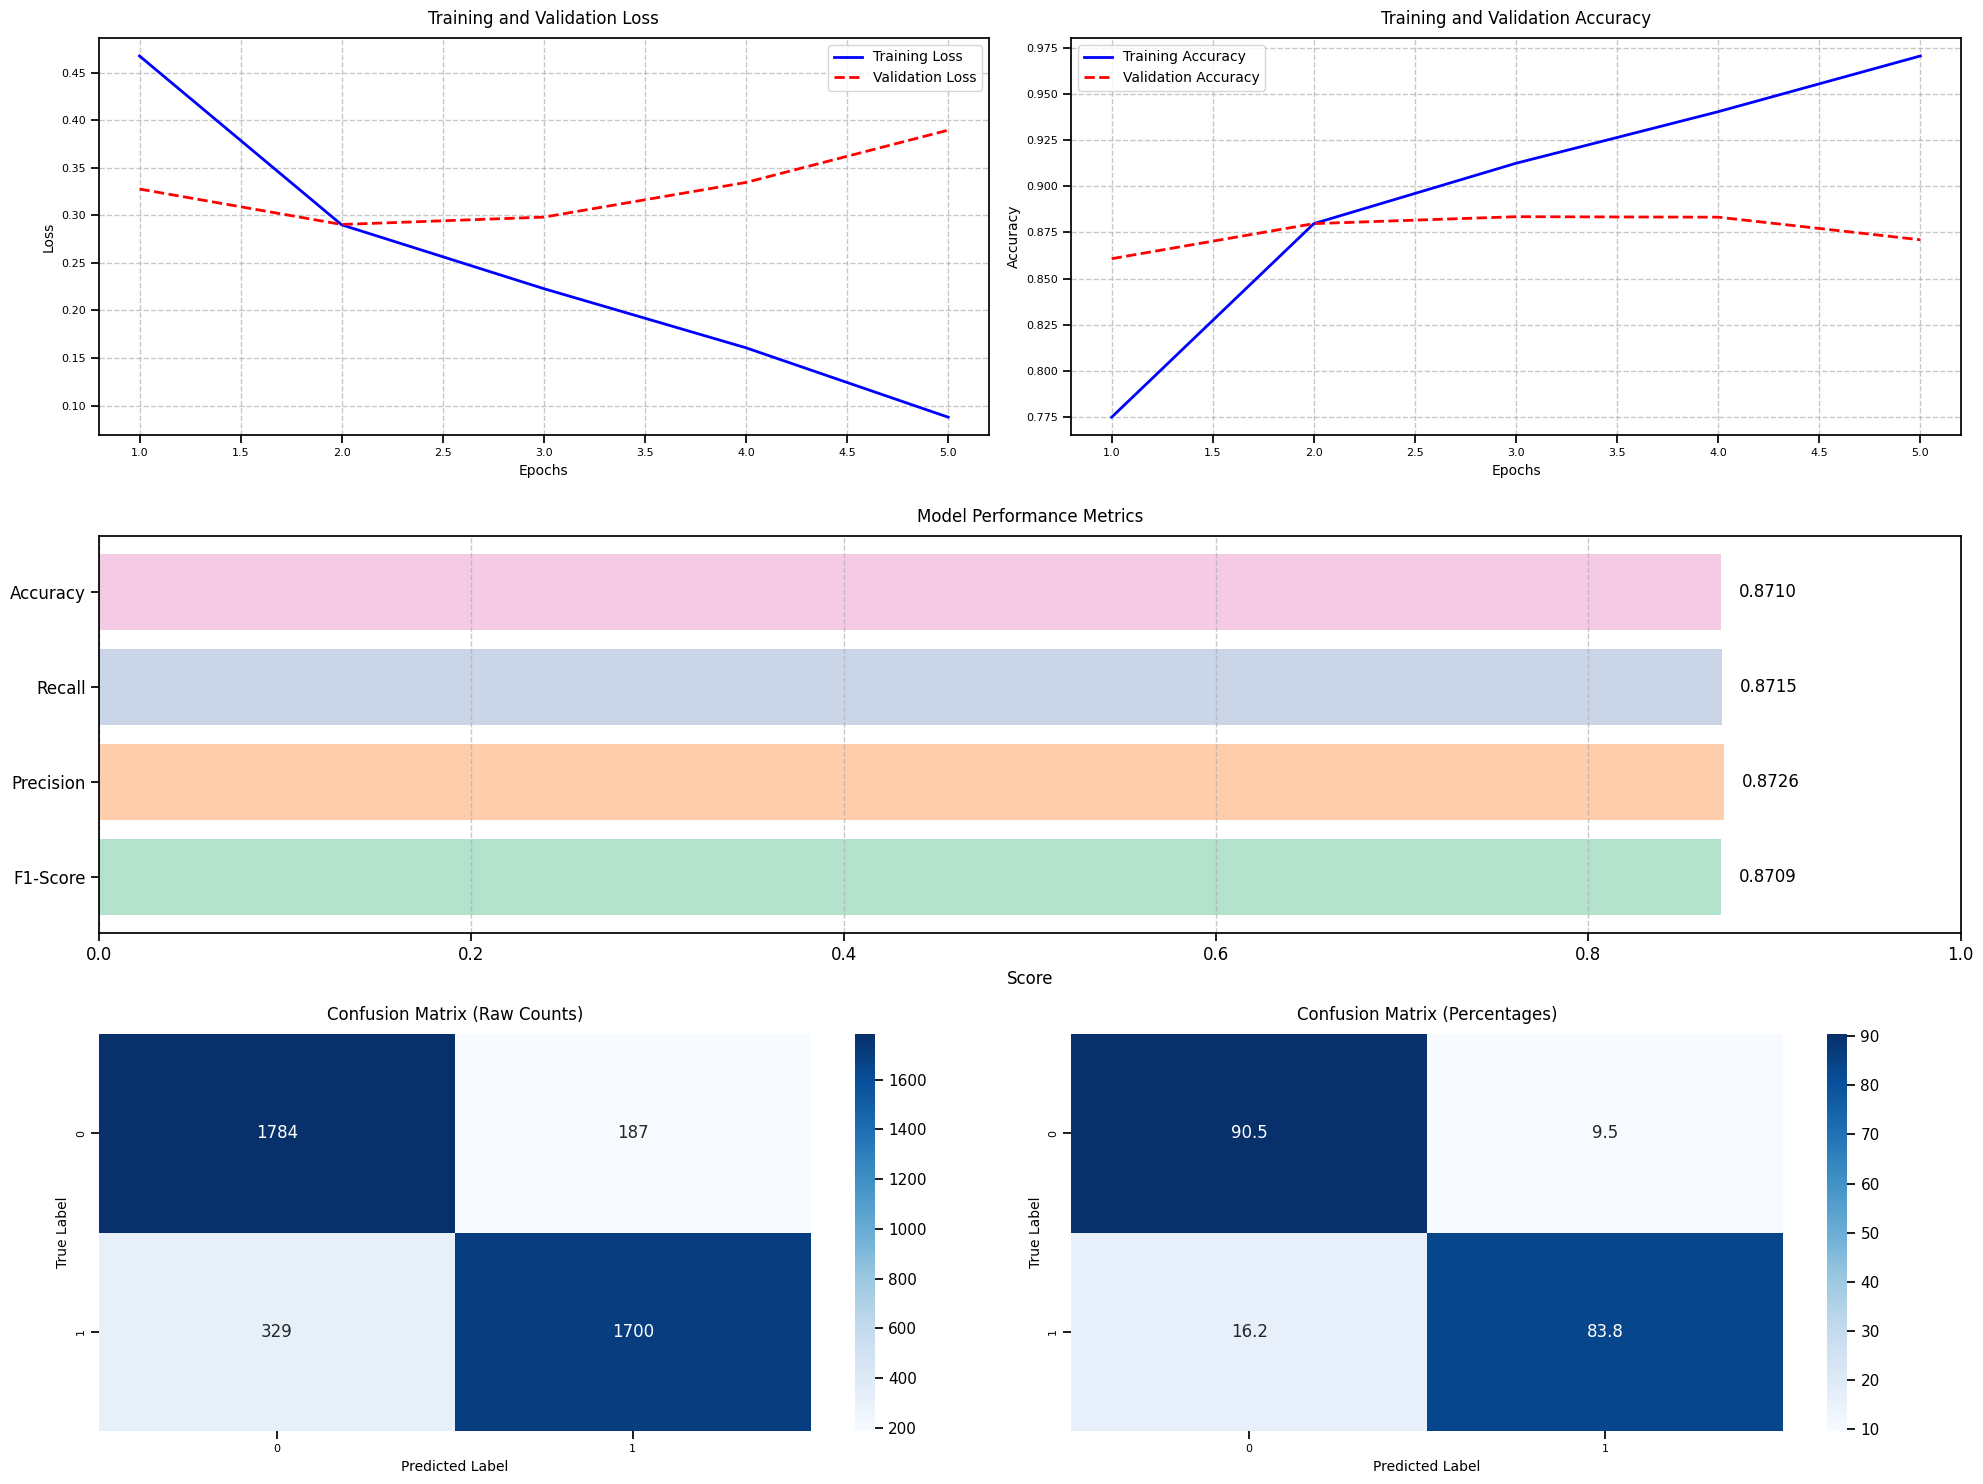

In [44]:
fig = create_performance_report(
    history['train_loss'], history['val_loss'],
    history['train_acc'], history['val_acc'],
    y_true, y_pred,
    epochs=history['epochs']
)
plt.show()

In [45]:
torch.save(model.state_dict(), 'sentiment_model.pth')

**Model Evaluation in Unseen Test Data**

In [46]:
# test loop
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

test_y_true = []
test_y_pred = []

testloop = tqdm(test_loader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)

        out = model(feature)

        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        test_y_true.extend(target.cpu().numpy())
        test_y_pred.extend(predicted.cpu().numpy())
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()
        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print(f'Accuracy: {test_acc/len(test_loader):.4f}, Loss: {test_loss/len(test_loader):.4f}')

Inference: 100%|██████████| 188/188 [00:04<00:00, 40.84it/s]

Accuracy: 0.8732, Loss: 0.3748


We are getting close to 88% Accuracy in Testing Data.

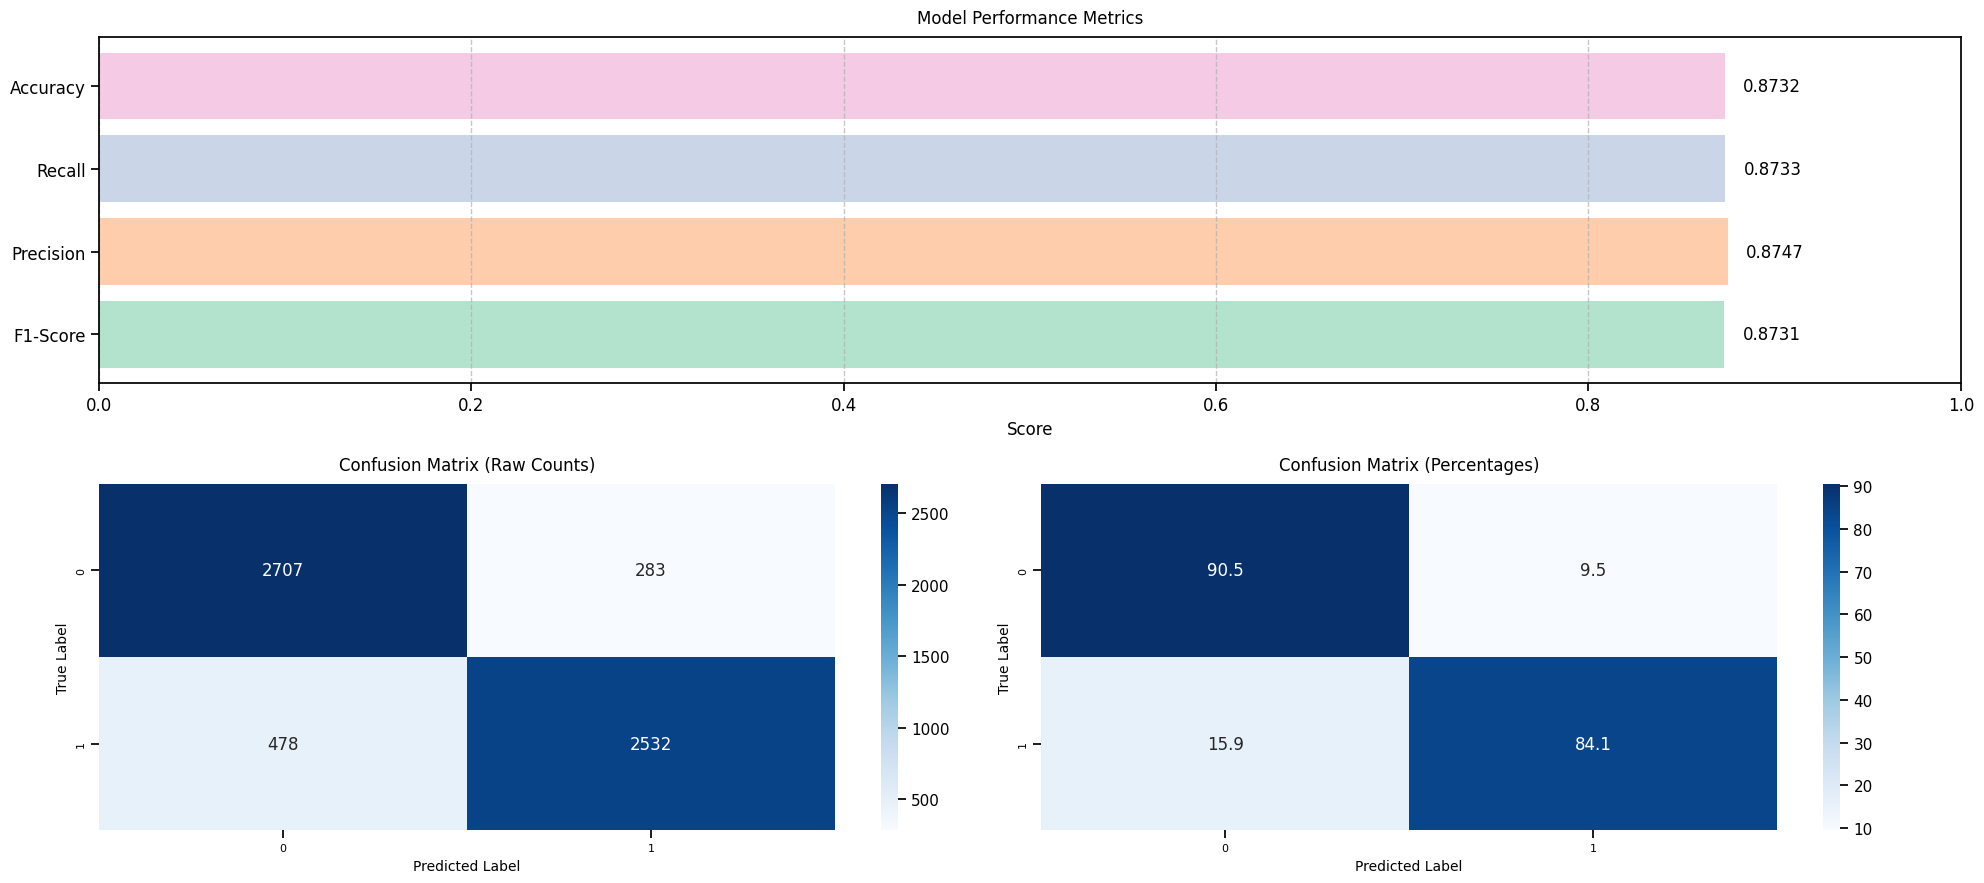

In [47]:
fig = display_metric_and_confusion_metrics(test_y_true, test_y_pred)
plt.show()

# Predicting realtime reviews from IMDB

In [4]:
with open("tokenizer.json", "r") as f:
    tokenizer_data = json.load(f)
    tokenizer = tokenizer_from_json(json.dumps(tokenizer_data))

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
model.load_state_dict(torch.load('sentiment_model.pth', map_location=device))
model.to(device)
model.eval()

C:\Users\RAJ\AppData\Local\Temp\ipykernel_25484\3536682934.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sentiment_model.pth', map_lo

SentimentModel(
  (embedding): Embedding(5000, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [9]:
reviews = [
    {
        "review": "Acting was trash, literally no plot whatsoever and a plethora of unnecessary scenes that had no connection with each other. The director didn't bother to highlight the actor and actresses lack of emotion whatsoever. I understand the want to be inclusive but it was all too overwhelming and it seemed so forced. Nothing was natural in here more like every single scene made me cringe. Definitely for those who watch for the vibes and not the plot not that there were any vibes or plot to start with! Wasted my time! If they made this drama in hopes of getting famous through its amaturity it sure did do its job!",
        "label": "Negative",
        "rating": "⭐"
    },
    {
        "review": "I can't agree with the negative reviews on here, sure it's not a deep artist masterpiece, but it is adorable and fun! I think the cast is all super cute and they did a really great job acting their parts. The characters I think r fleshed out and endearing.",
        "label": "Positive",
        "rating": "⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐"
    },
    {
        "review": "The Lion King (1994) is my favorite Disney Animated movie of all time and it has a special place in my heart. With that being said, I wasn't a fan of the 2019 live-action remake as it was basically the same movie with a couple of changes and the changes they made didn't sit well with me. So when I heard that Disney was going to make a prequel to the 2019 movie, I knew it was going to be bad especially after watching the trailer. Well I just finished watching the movie and I was proven right cause this movie was trash.",
        "label": "Negative",
        "rating": "⭐⭐⭐"
    },
    {
        "review": "As a longtime Lion King fan (I even had a Lion King decorated bathroom when I was a kid lol) I found this movie to be disappointing. The voices were hard to understand, following the character's timelines was difficult and the lack of catchy songs in the movie are a few examples of cons. The random snow scene and white lions? Didn't make a whole lot of sense. It seemed as if there were a lot of plot holes throughout the story. This movie is geared towards those who love Disney movies but it fell flat in attaining the attention span of children. Multiple kids in the theater were bored with the movie and were over it not even halfway through. This movie had a lot to be desired and is better fit to watch at home when it is released on streaming networks.",
        "label": "Negative",
        "rating": "⭐⭐⭐⭐"
    },
    {
        "review": "I absolutely love this movie, and I'm giving it a 10/10 in an attempt to boost its overall IMDb rating. It truly deserves to be at least an 8/10 overall. Mufasa: The Lion King does justice to The Lion King franchise, honoring the original while adding a fresh perspective. The added backstory brings so much depth to the narrative, enhancing the emotional connection to the characters and the world we already know and love. Every detail feels carefully crafted, and the storytelling is both engaging and heartfelt. It's a perfect blend of nostalgia and innovation, capturing the spirit of the original while standing strong on its own. I thoroughly enjoyed every moment of this movie and highly recommend it to fans of the franchise. Also the animators clearly took the criticism from the last movie to heart because the animation in Mufasa is much improved. The characters' emotions are portrayed far more effectively, and the facial expressions and mouth movements feel much more natural this time around.",
        "label": "Positive",
        "rating": "⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐"
    }
]

In [12]:
# Prediction Method
display_reviews(reviews, model, tokenizer)